# パネル・データ分析

In [1]:
import numpy as np
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
from collections import OrderedDict
import wooldridge
from statsmodels.formula.api import ols

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

パネル・データを使った次のモデルについて説明する。
* 固定効果モデル（Fixed Effects Model）
* ランダム効果モデル（Random Effects Model）
* 相関ランダム効果モデル（Correlated Random Effects Model） 

## 固定効果モデル

### 説明

パネル・データを使う場合の問題は観察単位の異質性を捉える変数 $a_i$ が説明変数 $x_{it}$ と相関することにより，単純なOLS推定量に異質性バイアスが発生することである。その対処方法として，回帰式から$a_i$をなくす１階差分推定について説明した。この章では，同じように$a_i$をなくす代替推定法として固定効果推定（Fixed Effects Estimator）について考える。まず，その基礎となる固定効果モデル（Fixed Effects Model; FEモデル）について解説する。

次式を考えよう。

$$y_{it}= \beta_0 + a_i + \beta_1x_{it}+u_{it}\qquad i=1,2,..,n\quad t=0,1,...,T\qquad\qquad\left(\text{式１}\right)$$

両辺のそれぞれの変数の時間に対しての平均を計算すると次式となる。

$$\bar{y}_i= \beta_0 + a_i + \beta_1\bar{x}_i+\bar{u}_i\qquad\qquad\left(\text{式２}\right)$$

（注意）$a_i$は時間に対して不変なため，$a_i$はそのままの値を取る。

(式１)と(式２)の差を取ると次の固定効果推定式が導出できる。

$$\ddot{y}_i = \beta_1\ddot{x}_i+\ddot{u}_i\qquad\qquad\left(\text{式３}\right)$$

ここで
* $\ddot{y}_i=y_i-\bar{y}$
* $\ddot{x}_i=x_i-\bar{x}$
* $\ddot{u}_i=u_i-\bar{u}$

は平均からの乖離（demeaned values）。

＜仮定と推定量の性質＞
1. (式１)のように回帰式は線形
1. 標本のランダム抽出
1. $x_{it}$は時間と共に変動し、説明変数間の完全多重共線性は存在しない。
1. $\text{E}(u_{it}|X_i,a_i)=0$、即ち、$a_i$ と $x_{it}$, $t=1,2,..,T$ を所与として $u_{it}$ の平均は0

この仮定の下で，OLS推定量 $\hat{\beta}_1$ は
* 不偏性を満たす。
* $T$を一定として標本の大きさが十分に大きい場合，一致性を満たす。
* 固定効果推定量（Fixed Effects Estimator or FE Estimator）もしくは Within Estimatorと呼ばれる。


<br>

---
＜良い点＞
* 推定量は上述の仮定の下で不偏性・一致性が満たされる。

＜悪い点＞
* 時間に対して一定の説明変数は，$a_i$と同じように，（式３）に残らない。従って，時間不変の変数の効果を推定することはできない。

### 「手計算」による推定

`wagepan`というデータセットを使い，賃金に対する労働組合などの変数の効果を推定する。

In [2]:
wagepan = wooldridge.data('wagepan')
wooldridge.data('wagepan', description=True)

name of dataset: wagepan
no of variables: 44
no of observations: 4360

+----------+------------------------+
| variable | label                  |
+----------+------------------------+
| nr       | person identifier      |
| year     | 1980 to 1987           |
| agric    | =1 if in agriculture   |
| black    | =1 if black            |
| bus      |                        |
| construc | =1 if in construction  |
| ent      |                        |
| exper    | labor mkt experience   |
| fin      |                        |
| hisp     | =1 if Hispanic         |
| poorhlth | =1 if in poor health   |
| hours    | annual hours worked    |
| manuf    | =1 if in manufacturing |
| married  | =1 if married          |
| min      |                        |
| nrthcen  | =1 if north central    |
| nrtheast | =1 if north east       |
| occ1     |                        |
| occ2     |                        |
| occ3     |                        |
| occ4     |                        |
| occ5     |     

被説明変数
* `lwage`：賃金（対数）

説明変数
* `union`：労働組合参加（ダミー変数）
* `married`：未・既婚（ダミー変数）
* `exper`：労働市場参加年数
*  `d81`：1981年のダミー変数
*  `d82`：1982年のダミー変数
*  `d83`：1983年のダミー変数
*  `d84`：1984年のダミー変数
*  `d85`：1985年のダミー変数
*  `d86`：1986年のダミー変数
*  `d87`：1987年のダミー変数

`DataFrame`の`groupby`を使って変数をグループ化する際に使う変数
* `nr`：労働者のID

```{admonition} コメント
:class: tip
時間に対して変化しない変数は使えない。例えば，
* `educ`（説明変数に入れば教育の収益率が推定可能である。）
* `black`，`hisp`（を使うと人種間の賃金格差も推定できる。）

は固定効果モデル回帰式には入れることができない。
```

In [3]:
# 説明変数のリスト
exog = ['married','union','expersq','d81','d82','d83','d84','d85','d86','d87']

# 全ての変数のリスト
var = ['lwage']+exog

# 使う変数だけで構成されるDataFrame
df = wagepan.loc[:,['nr']+var]

# varの平均からの乖離を計算（下の説明（１）を参照）
df_g = df.groupby('nr')
df_mean = df_g[var].transform('mean')
df_md = df.loc[:,var]-df_mean

# 説明変数の行列（下の説明（２）を参照）
X = df_md.loc[:,exog].values

# 被説明変数のベクトル
Y = df_md.loc[:,'lwage'].values

# OLSの計算
params = np.linalg.inv((X.T)@X)@(X.T)@Y

# 結果の表示（下の説明（３）を参照）
for idx, name in enumerate(exog):
    print(f'{name}: {params[idx]:.4}')

married: 0.04668
union: 0.08
expersq: -0.005185
d81: 0.1512
d82: 0.253
d83: 0.3544
d84: 0.4901
d85: 0.6175
d86: 0.7655
d87: 0.925


説明（１）
* `df.groupby('nr')`：`nr`でグループ化したオブジェクトを作成する（番外編のGapminderを参照）。
* `df_g[var].transform('mean')`
    * `df_g[var]`：グループ化計算のために`var`の変数だけを使うことを指定する。
    * `.transform('mean')`：指定された変数（`var`）のグループ内平均（それぞれの`nr`内での平均）を計算し，その平均で構成される`DataFrame`を作成する。作成された`DataFrame`の行数は`df`と同じになり，グループ内平均が同じ列内でリピートされることになる。
* `df.loc[:,var]-df_mean`：`var`のそれぞれの変数の平均からの乖離を計算する。
* `df_mean = ...`と`df_md = ...`の2行を次のように1行にまとめることも可能。
    * `df_md = df_g[var].transform(lambda x: x-x.mean())`

説明（２）
* `.values`は`DataFrame`を`numpy`の`array`として返す。

説明（３）
* `enumerate(exog)`は`exog`の変数のインデックスと変数名の両方をタプルとして返す。
    * `for`ループで`enumerate()`は，引数にリストや`array`を入れると2つの値を返す。
    * 1つ目の返り値：要素のインデックス
    * 2つ目の返り値：要素自体
    * 例えば，`enumerate(['A','B','C'])`であれば，返り値は`(0,'A')`，`(1,'B')`，`(2,'C')`となる。
* `f'{name}: {params[idx]:.4}'`
    * `f`：以前説明したf-string
    * `{name}`：`exog`の変数名を代入する。
    * `{params[idx]:.4}`
        * `params[idx]`：`idx`番目の`params`を代入する。
        * `:.4`：小数点第4位までを表示する。

---
「手計算」の結果は`linearmodels`を使う結果と同じになることを下で確認する。

### `linearmodels`を使う計算

#### EntityEffects

`linearmodels`には`PanelOLS`モジュールがあり，その関数`from_formula()`を使うことにより，`statsmodels`同様，回帰式を`y ~ x`の文字列で書くことが可能となる。その際，次の点に注意すること。
* 固定効果推定をする場合，回帰式に`+ EntityEffect`を含める。
    * このオプションにより変数の平均からの乖離は自動で計算されることになる。
    * `+ EntityEffect`を含めないと`PooledOLS`（通常のOLS）と等しくなる。


まず`wagepan`を`MultiIndex`化する。これにより`linearmodels`を使いFD推定可能となる。

In [4]:
wagepan = wagepan.set_index(['nr','year'],drop=False)

In [5]:
wagepan.head()

nr  year  agric  black  bus  construc  ent  exper  fin  hisp  ...  \
nr year                                                                ...   
13 1980  13  1980      0      0    1         0    0      1    0     0  ...   
   1981  13  1981      0      0    0         0    0      2    0     0  ...   
   1982  13  1982      0      0    1         0    0      3    0     0  ...   
   1983  13  1983      0      0    1         0    0      4    0     0  ...   
   1984  13  1984      0      0    0         0    0      5    0     0  ...   

         union     lwage  d81  d82  d83  d84  d85  d86  d87  expersq  
nr year                                                               
13 1980      0  1.197540    0    0    0    0    0    0    0        1  
   1981      1  1.853060    1    0    0    0    0    0    0        4  
   1982      0  1.344462    0    1    0    0    0    0    0        9  
   1983      0  1.433213    0    0    1    0    0    0    0       16  
   1984      0  1.568125    0    0    0    1    0    0    0       25  

[5 rows x 44 columns]

In [6]:
wagepan.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4360 entries, (13, 1980) to (12548, 1987)
Data columns (total 44 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nr        4360 non-null   int64  
 1   year      4360 non-null   int64  
 2   agric     4360 non-null   int64  
 3   black     4360 non-null   int64  
 4   bus       4360 non-null   int64  
 5   construc  4360 non-null   int64  
 6   ent       4360 non-null   int64  
 7   exper     4360 non-null   int64  
 8   fin       4360 non-null   int64  
 9   hisp      4360 non-null   int64  
 10  poorhlth  4360 non-null   int64  
 11  hours     4360 non-null   int64  
 12  manuf     4360 non-null   int64  
 13  married   4360 non-null   int64  
 14  min       4360 non-null   int64  
 15  nrthcen   4360 non-null   int64  
 16  nrtheast  4360 non-null   int64  
 17  occ1      4360 non-null   int64  
 18  occ2      4360 non-null   int64  
 19  occ3      4360 non-null   int64  
 20  occ4      43

次に`PanelData`オブジェクトに変換しデータの特徴を調べる。

In [7]:
wagepanp = PanelData(wagepan)
wagepanp.shape

(44, 8, 545)

* 44: 変数の数
* 8: 期間数（年）
* 545：観察単位の数（人数）

次に，balanced もしくは unbalanced data set かを確認する。

In [8]:
(~wagepanp.isnull).all()

True

このデータ・セットはbalancedだが，unbalanced だったとしても，固定効果モデルの考え方や以下で説明するコードは変わらない。

---
実際に回帰式を書くことにする。使い方は`statsmodels`と似ている。
* `PanelOLS`モジュールの関数`.from_formula`を使い次のように引数を指定する。

$$\text{.from_formula}(\text{回帰式}, \text{データ})$$

* `EntityEffects`を加える。
* 定数項を入れたい場合は，`1`を回帰式に追加する。入れなければ定数項なしの推定となる。

* 以下では時間ダミー`C(year)`が入るので入れない。

In [9]:
formula_fe = 'lwage ~ married + union + expersq \
                      +d81+d82+d83+d84+d85+d86+d87 + EntityEffects'

* 固定効果モデルのインスタンスの作成

In [10]:
mod_fe = PanelOLS.from_formula(formula_fe, data=wagepan)

* `statsmodels`と同じように，そこから得た結果にメソッド`.fit()`を使い計算し結果が返される。

In [11]:
result_fe = mod_fe.fit()

＜結果の表示方法＞
1. `res_fe`を実行。
1. `res_fe`に関数`print()`を使うと見やすい。
1. `res_fe`には属性`summary`が用意されているが，表示方法1と同じ。
1. `summary`には属性`tables`があり，２つの表がリストとして格納されている。
    * `tables[0]`：検定統計量の表（`print()`を使うと見やすくなる）
    * `tables[1]`：係数の推定値やp値などの表（`print()`を使うと見やすくなる）

In [12]:
print(result_fe.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.0467     0.0183     2.5494     0.0108      0.0108      0.0826
union          0.0800     0.0193     4.1430     0.0000      0.0421      0.1179
expersq       -0.0052     0.0007    -7.3612     0.0000     -0.0066     -0.0038
d81            0.1512     0.0219     6.8883     0.0000      0.1082      0.1942
d82            0.2530     0.0244     10.360     0.0000      0.2051      0.3008
d83            0.3544     0.0292     12.121     0.0000      0.2971      0.4118
d84            0.4901     0.0362     13.529     0.0000      0.4191      0.5611
d85            0.6175     0.0452     13.648     0.0000      0.5288      0.7062
d86            0.7655     0.0561     13.638     0.0000      0.6555      0.8755
d87            0.9250     0.0688     13.450     0.00

（結果）
* `exper**2`の係数が負で統計的有意性が高いのは，賃金に対して経験の効果は低減することを示している。
* `married`の係数は正であり，優位性が全くないわけではない。賃金の既婚プレミアムと呼ばれるものである。
* `union`は労働組合の影響を示しているが，予測通りである。

$R^2$を表示してみる。

In [13]:
print(result_fe.summary.tables[0])

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1806
Estimator:                   PanelOLS   R-squared (Between):              0.2386
No. Observations:                4360   R-squared (Within):               0.1806
Date:                Mon, Nov 09 2020   R-squared (Overall):              0.2361
Time:                        20:17:07   Log-likelihood                   -1324.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      83.851
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(10,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             83.851
                            

この表にある$R^2$について説明する。
* $R^2$＝$R^2(\text{Within})$：(式３)を推定した際の$R^2$である（$\ddot{y}_i$が$\ddot{x}_i$によってどれだけ説明されたかを示す）。
* $R^2(\text{Between})$：(式２)を推定した際の$R^2$である（$\hat{y}_i$が$\hat{x}_i$によってどれだけ説明されたかを示す）。
* $R^2(\text{Overall})$：(式１)を推定した際の$R^2$である（${y}_i$が${x}_i$によってどれだけ説明されたかを示す）。

#### TimeEffects

上の推定式では時間ダミー変数として使い，観察単位全てに共通な時間的な影響を捉えた。具体的には，インフレにより賃金は変化するが，その変化は全ての労働者には対して同じであり，その効果を時間ダミー変数が捉えている。それを**時間効果**と呼ぶ。このような時間ダミー変数を加えた理由は，時間効果が他の変数（例えば，`married`）の係数を「汚さない」ようにするためであり，よりピュアの効果を推定するためである。一方，`linearmodels`では，わざわざ時間ダミー変数を作らずとも`TimeEffects`を回帰式に追加することにより，時間効果を自動的に「排除」することができる。

In [14]:
formula_fe2 = 'lwage ~ married + union + expersq + TimeEffects + EntityEffects'
result_fe2 = PanelOLS.from_formula(formula_fe2, data=wagepan).fit()
print(result_fe2)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0216
Estimator:                   PanelOLS   R-squared (Between):             -0.2717
No. Observations:                4360   R-squared (Within):              -0.4809
Date:                Mon, Nov 09 2020   R-squared (Overall):             -0.2808
Time:                        20:17:07   Log-likelihood                   -1324.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.959
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(3,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             27.959
                            

`result_fe`と同じ結果を確認できる。$R^2$の値は少し変わっているが，これは時間ダミーを入れて計算している訳ではないためである。

## ダミー変数モデルとしての固定効果モデル

固定効果推定量は，他の推定方法でも計算することができる。その１つがダミー変数推定である。アイデアは簡単で，観察単位のダミー変数を使い異質性を捉えるのである。推定方法も簡単で，（式１）に観察単位のダミー変数を加えて通常のOLS推定をおこなうだけである。

上で使った`wagepan`を使い推定する。まず，観察単位のダミー変数として推定式に`C(nr)`を追加する

In [15]:
formula_dum = 'lwage ~  1 + married + union + expersq \
                        +d81+d82+d83+d84+d85+d86+d87 + C(nr)'

`PooledOLS`モジュールの関数`from_formula`を使って推定式を定義する。ここで`PooledOLS`とは，`statsmodels`で使う通常のOLS推定と同じである。

In [16]:
result_dum = PooledOLS.from_formula(formula_dum, data=wagepan).fit()

`nr`のダミー変数が544あるため，そのまま結果を表示せずに，以下のセルにあるフィルターを使いメインの変数だけを表示する。下のコードの`filter`で使う（`result_dum`に続く）属性・メソッドについて：
* `params`：パラメーターを取得する属性
* `index`：`params`のインデックスを取得する属性
* `str`：`index`にある文字列を操作可能なオブジェクトとして取得する属性
* `contains()`：引数の文字列が文字列の中にある場合`True`を返すメソッド
* `( )`：括弧の中を先に評価するという意味
* `tolist()`：リストに変換するメソッド

In [17]:
filter = (result_dum.params.index.str.contains('nr') == False).tolist()
result_dum.params[filter]

Intercept    0.933291
married      0.046680
union        0.080002
expersq     -0.005185
d81          0.151191
d82          0.252971
d83          0.354444
d84          0.490115
d85          0.617482
d86          0.765497
d87          0.925025
Name: parameter, dtype: float64

３つの変数`I(exper**2)`，`married`，`union`の係数は固定効果モデルと等しいことが確認できる。

t値とp値の表示には次のコードを使う。
* t値：`result_dum.tstats[filter]`
* p値：`result_dum.pvalues[filter]`

この場合，`educ`等の時間に対して不変の変数も推定式に加えることが可能である。一方，この方法はパラメーターの数は544+11=555あり，自由度が非常に低くなるのが欠点である。


（注意）

この推定式に時間に対して不変の変数（例えば，`educ`，`blac`，`hisp`，`exper`）を追加すると推定できない（エラーが発生する）。理由は，それらの変数は`nr`ダミー変数と完全に同じ動きをするためである。

## ランダム効果モデル

### 説明

ここでは，パネル・データを使い推定するランダム効果モデル（Random Effects Model; RE Model）を解説する。もう一度（式１）を考えよう。

（仮定） $a_i$は観察単位 $i$ に対して一定であるが，$i$によってその値は異なる。

＜固定効果モデルの仮定＞
* $\text{Cov}\left(a_ix_{it}\right)\neq 0,\quad t=1,2,...,T$

＜ランダム効果モデルの仮定＞
* $\text{Cov}\left(a_ix_{it}\right)=0,\quad t=1,2,...,T$

---
この違いを念頭に（式１）を次式に書き換える。

$$y_{it}= \beta_0 + \beta_1x_{it}+e_{it}\qquad\qquad\left(\text{式４}\right)$$

ここで，

$$e_{it}=a_i+u_{it}$$

しかし，

$$\text{Corr}\left(e_{it},e_{is}\right)\neq 0,\quad t\neq s$$

となることが示せる。即ち，誤差項が自己相関することになる。

＜含意＞
* $a_i$と$x_{it}$に相関がないため次の推定方法で一致性を満たす推定量を計算できる。
    * １つの時点でお横断面データを使いOLS推定（でも他のデータはどうする？）
    * 全てのデータを使い何の区別もなくプールするPooled OLS推定（しかしパネル・データの特性を有効利用していない）。
* 時系列データを扱う場合，自己相関によりOLS推定量は効率性が低くなる。これは横断面データを扱う際の不均一分散が引き起こす問題と似ている。
* １階差分推定や固定効果推定を使う必要はなく，使うと効率性が低い推定量となる。
* 従って，問題は次の点：
    * より効率性が高い推定方法はどのようなものか。

---
その方法がランダム効果推定と言われるもので，固定効果のように，変数を平均からの**部分的**な乖離に変換することにより可能となる。具体的には，次式が推定式となる。

$$\overset{\circ}{y}_{it}=\beta_0(1-\theta)+\beta_1\overset{\circ}{y}_{it}+\overset{\circ}{e}_{it}\qquad\qquad\left(\text{式５}\right)$$

ここで
* $\overset{\circ}{y}_{it}=y_{it}-\theta\bar{y}_i$
* $\overset{\circ}{x}_{it}=x_{it}-\theta\bar{x}_i$
* $\overset{\circ}{e}_{it}=e_{it}-\theta\bar{e}_i$

は変数の平均からの部分的な乖離であり，乖離の度合いを決める変数$\theta$は

 $$\theta = 1-\sqrt{\frac{\sigma_u^2}{\sigma_u^2+T\sigma_a^2}}$$

と定義される。$\sigma_u^2$は$u_{it}$の分散，$\sigma_a^2$は$a_{i}$の分散である。



（直感）
* $\sigma_a^2=0$の場合$\theta=0$となり，$a_i$は$i$に対して一定であり観察単位の異質性はないということである。その場合は，通常のOLSで推定することがベストとなる。
* $\sigma_a^2$が増加すると$\theta$は大きくなり，より大きな平均からの乖離が必要となる。極端な場合，$\sigma_a^2$が無限大に近づくと，$\theta=1$となり$\overset{\circ}{y}=\ddot{y}$となる。即ち，固定効果モデルはランダム効果モデルの極端な場合と解釈できる。

（注意）
* $\theta$は事前にはわからないため推定する必要がある（`linearmodels`が自動的に計算する）。

＜仮定と推定量の性質＞
1. (式１)のように回帰式は線形
1. 標本のランダム抽出
1. 説明変数間の完全多重共線性は存在しない。
1. 説明変数を所与として$a_i$の平均は一定。（従って、$\text{Cov}\left(a_ix_{it}\right)= 0$。）

この仮定の下で，RE推定量 $\hat{\beta}_1$ は
* 一致性を満たす。しかし不偏性は満たさない。


<br>

---
（良い点）
* 時間に対して不変の説明変数があってもその係数を推定できる。

### 推定

`exper`，`educ`，`black`，`hisp`を加えて回帰式を定義する。

（注意）

時間ダミー変数の代わりに`TimeEffects`を使わないように。入れることができますが，そのような仕様になっていません。

In [18]:
formula_re = 'lwage ~ 1 + married + union + expersq \
                        + exper + educ + black + hisp \
                        +d81+d82+d83+d84+d85+d86+d87'

`RandomEffects`のモジュールにある関数`from_formula`を使い計算する。

In [19]:
result_re = RandomEffects.from_formula(formula_re, data=wagepan).fit()

結果の表示。

In [20]:
print(result_re.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0234     0.1514     0.1546     0.8771     -0.2735      0.3203
married        0.0638     0.0168     3.8035     0.0001      0.0309      0.0967
union          0.1059     0.0179     5.9289     0.0000      0.0709      0.1409
expersq       -0.0047     0.0007    -6.8623     0.0000     -0.0061     -0.0034
exper          0.1058     0.0154     6.8706     0.0000      0.0756      0.1361
educ           0.0919     0.0107     8.5744     0.0000      0.0709      0.1129
black         -0.1394     0.0480    -2.9054     0.0037     -0.2334     -0.0453
hisp           0.0217     0.0428     0.5078     0.6116     -0.0622      0.1057
d81            0.0404     0.0247     1.6362     0.1019     -0.0080      0.0889
d82            0.0309     0.0324     0.9519     0.34

結果の解釈は下でする。

RE推定では$\theta$が重要な役目を果たすが，その値は`result_re`の属性`theta`を使うことにより`DataFrame`の形で表示できる。
* balanced panel dataの場合，`theta`の値は一意で決まる。
* unbalanced panel dataの場合，`theta`は観察単位毎に計算される。

In [21]:
result_re.theta.iloc[0,:]

theta    0.645059
Name: 13, dtype: float64

上で説明したが$\theta$は$u_a$と$u_it$の分散である$\sigma_a^2$と$\sigma_u^2$に依存する。それらの値は，属性`variance_decomposition`を表示できる。以下の返り値の内容：
* `Effects`：$\sigma_a^2$
* `Residual`：$\sigma_u^2$
* `Percept due to Effects`：$\dfrac{\sigma_a^2}{\sigma_a^2+\sigma_u^2}$

In [22]:
result_re.variance_decomposition

Effects                   0.106946
Residual                  0.123324
Percent due to Effects    0.464438
Name: Variance Decomposition, dtype: float64

## 相関ランダム効果モデル

### 説明

相関ランダム効果モデル（CREモデル）は，固定効果モデルとランダム効果モデルの中間的な位置にあり，両方を包含している。（式１）を考えよう。更に，観察不可能な固定効果$a_i$は説明変数と次の関係にあると仮定する。

$$a_i = \alpha + \gamma\bar{x}_{it} + r_i\qquad\text{(式５)}$$

* $\bar{x}_i=\dfrac{1}{T}\sum_{t=1}^Tx_{it}$は説明変数の平均
* $\gamma$は$a_i$と$x_{it}$の相関関係を捉える係数
* $r_i$は説明変数$x_{it}$と相関しないと仮定，即ち，$\text{Cov}\left(r_i\bar{x}_{it}\right)$

（式５）を（式１）に代入すると次式を得る。

$$y_{it}=\alpha+\beta x_{it} + \gamma\bar{x}_i + v_{it}\qquad\text{(式６)}$$

ここで

$$v_{it}=r_i + u_{it}$$

（含意）
* $\text{Cov}\left(r_i,\bar{x}_{it}\right)\;\Rightarrow\;\text{Cov}\left(v_i,\bar{x}_{it}\right)$
* REモデルと同じ構造となっており，違いは$\bar{x}_i$が追加されている。
    * `linearmodels`の`RandomEffects`モジュールが使える。
* 次の結果が成立する。

    $$\hat{\beta}_{FE}=\hat{\beta}_{CRE}$$
    
    * $\hat{\beta}_{FE}$：固定効果推定量
    * $\hat{\beta}_{CRE}$：相関ランダム効果推定量
    * この結果は，時間に対して不変な変数（例えば，`black`）を**含めても**成立する

### 推定

まず $\bar{x}_i$ を計算し，それを`wagepan`に追加する。そのために次の関数を定義する。

（解説）

* (1)：関数の引数
    * `dframe`：データフレーム
    * `ori_col`：平均を計算したい列
    * `new_col`：計算した平均を入れる列
* (2)：`ori_col`をグループ化し，グループ名とグループ平均からなる辞書の作成
    * `groupby(level=0)`：行の第１インデックスに従ってグループ化
    * `mean()`：グループ平均の計算
    * `to_dict()`：行の第１インデックスにあるグループ名を`key`，グループ平均を`value`にする辞書の作成
* (3)：行の第１インデックスに該当するグループ平均が並ぶリストの作成
    * `index.get_level_values(0)`：行の第１インデックスの値を取得
    * `to_series()`：`series`に変換
    * `map(dict)`：`dict`の内容に従って上の`series`の値をグループ平均に入れ替える
    * `tolist()`：リストに変換
* (4)：`dframe`にグループ平均が並ぶ新しい列が追加し，そのラベルを`new_col`とする
* (5)：`DataFrame`を返す

In [23]:
def add_col_mean(dframe, ori_col, new_col):  # (1)
    
    dict = dframe.groupby(level=0)[ori_col].mean().to_dict()  # (2)
    mean = dframe.index.get_level_values(0).to_series().map(dict).tolist()  # (3)
    dframe.loc[:,new_col] = mean  # (4)
    
    return dframe   # (5)

この関数を使い，`married`，`union`，`expersq`の平均を計算し`wagepan`に追加する。

（コメント）`exper`は含めない。

In [24]:
wagepan = add_col_mean(wagepan, 'married', 'married_mean')
wagepan = add_col_mean(wagepan, 'union', 'union_mean')
wagepan = add_col_mean(wagepan, 'expersq', 'expersq_mean')

CRE推定と結果の表示

In [25]:
formula_cre = 'lwage ~ 1 + married + union + expersq \
                         + married_mean + union_mean + expersq_mean \
                         +d81+d82+d83+d84+d85+d86+d87'

result_cre = RandomEffects.from_formula(formula_cre, data=wagepan).fit()

print(result_cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lwage   R-squared:                        0.1711
Estimator:              RandomEffects   R-squared (Between):              0.0967
No. Observations:                4360   R-squared (Within):               0.1806
Date:                Mon, Nov 09 2020   R-squared (Overall):              0.1355
Time:                        20:17:08   Log-likelihood                   -1609.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      69.027
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(13,4346)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             69.027
                            

### ２つの利点

CREモデルの２つの利点を解説する。

#### FE対RE検定

FEモデルとREモデルのどちらが適しているかを調べることができるHausman検定というものがある。CREモデルを使うことにより，同様の検定が簡単に行える。（式６）を考えよう。
* $\gamma=0$の場合，REモデルの（式５）と同じになり，REモデルが妥当ということになる。
* $\gamma\neq 0$の場合，$a_i$と$\bar{x}_{i}$は相関することになり，これは$\text{Cov}\left(a_i,{x}_{it}\right)\neq 0$を意味し，REモデルが妥当な推定方法となる。

この考えを利用して，次の帰無仮説と対立仮説のもとで$\gamma$の優位性を調べる。
* $\text{H}_0:\;\text{Cov}\left(a_i,x_{it}\right)=0$
* $\text{H}_a:\;\text{Cov}\left(a_i,x_{it}\right)\neq 0$

（コメント）
* $\gamma=0$を棄却できれば上の$\text{H}_0$を棄却できる。
* 平均の変数が$k$ある場合は，$\gamma_1=\gamma_2=\cdots=\gamma_k=0$を検定する。

`result_cre`のメソッド`wald_test()`を使う。引数には文字列で指定する。

In [26]:
# 検定する係数の値を設定する
restriction = 'married_mean = union_mean = expersq_mean = 0'

# 検定結果を表示する
result_cre.wald_test(formula=restriction)

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 35.6454
P-value: 0.0000
Distributed: chi2(3)
WaldTestStatistic, id: 0x7fd9e9996670

p値が非常に小さいので，帰無仮説は棄却できる。従って，FEモデルが妥当だと結論づけることができる。

#### 一定な変数を含める

（式６）に時間に対して一定は変数（$z_{i}$）を含めて

$$y_{it}=\alpha+\beta x_{it}+\gamma\bar{x}_i+\delta z_{i} +v_{it}\qquad\text{(式６)}$$

をRE推定しても次の結果は成立する。

$$\hat{\beta}_{FE}=\hat{\beta}_{CRE}$$

---
この結果を利用して，以下では次の変数を加えて回帰式を設定する。
* 時間に対して一定な変数
    * `educ`, `black`，`hisp`
* 一定ではないが，FEにいれると推定できなかった変数
    * `exper`

In [27]:
formula_cre2 = 'lwage ~ 1 + married + union + expersq \
                          + exper + educ + black + hisp \
                          + married_mean + union_mean + expersq_mean \
                          +d81+d82+d83+d84+d85+d86+d87'

result_cre2 = RandomEffects.from_formula(formula_cre2, data=wagepan).fit()

print(result_cre2.summary.tables[1])

                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept       -0.1288     0.1583    -0.8140     0.4157     -0.4391      0.1814
married          0.0467     0.0183     2.5520     0.0107      0.0108      0.0825
union            0.0800     0.0193     4.1473     0.0000      0.0422      0.1178
expersq         -0.0052     0.0007    -7.3689     0.0000     -0.0066     -0.0038
exper           -0.0504     0.0507    -0.9947     0.3200     -0.1499      0.0490
educ             0.0946     0.0110     8.6115     0.0000      0.0731      0.1161
black           -0.1388     0.0492    -2.8193     0.0048     -0.2353     -0.0423
hisp             0.0048     0.0430     0.1110     0.9116     -0.0795      0.0891
married_mean     0.0970     0.0454     2.1382     0.0326      0.0081      0.1859
union_mean       0.1907     

もう一度，FE対RE検定を行ってみよう。検定統計量（Statistics）は減少したが，以前帰無仮説は高い優位性で棄却できる。

In [28]:
result_cre2.wald_test(formula=restriction)

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 26.0233
P-value: 0.0000
Distributed: chi2(3)
WaldTestStatistic, id: 0x7fd9d1091fd0

## モデルの比較

パネル・データを扱う場合の通常のアプローチは，使える推定法を使いその結果を比べることから始める。以下では以下のモデルを比べる。
* 通常のOLS
* 固定効果モデル
* ランダム効果モデル
* 相関ランダムモデル

### OLS

`linearmodels`のモジュール`PooledOLS`では，観察単位や時間の区別なく全てのデータをプールしてOLS推定する。これは通常のOLSと同じ推定法と等しい。`PooledOLS`の関数`from_formula`を使い，以下のように推定する。

In [29]:
formula_pool = 'lwage ~ 1 + married + union + expersq \
                        + exper + educ + black + hisp \
                        +d81+d82+d83+d84+d85+d86+d87'

result_pool = PooledOLS.from_formula(formula_pool, data=wagepan).fit()

print(result_pool.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0921     0.0783     1.1761     0.2396     -0.0614      0.2455
married        0.1083     0.0157     6.8997     0.0000      0.0775      0.1390
union          0.1825     0.0172     10.635     0.0000      0.1488      0.2161
expersq       -0.0024     0.0008    -2.9413     0.0033     -0.0040     -0.0008
exper          0.0672     0.0137     4.9095     0.0000      0.0404      0.0941
educ           0.0913     0.0052     17.442     0.0000      0.0811      0.1016
black         -0.1392     0.0236    -5.9049     0.0000     -0.1855     -0.0930
hisp           0.0160     0.0208     0.7703     0.4412     -0.0248      0.0568
d81            0.0583     0.0304     1.9214     0.0548     -0.0012      0.1178
d82            0.0628     0.0332     1.8900     0.05

### 比較表の作成

今までの推定結果を表にまとめるために，`linearmodels`の関数`compare`を使う。

表作成の順番：
1. `key`が表示したい推定方法の名前，`value`がその上で得た推定結果となる辞書を作る
1. その辞書を`compare`の引数としてつかう。

In [30]:
res = {'Pooled OLS':result_pool,
       'FE': result_fe,
       'RE': result_re,
       'CRE': result_cre2
      }

# compare(res)

このままでも良いか，この方法では推定結果を表示する順番を指定できない。例えば，`OLS`，`FE`，`RE`，`CRE`の順番で左から並べたいとしよう。その場合，`collections`パッケージにある関数`OrderedDict`をつかう。`{}`の中で並べた順番をそのまま維持してくれる関数である。

In [31]:
res_ordered = OrderedDict(res)
print(compare(res_ordered))

                                     Model Comparison                                    
                            Pooled OLS             FE                RE               CRE
-----------------------------------------------------------------------------------------
Dep. Variable                    lwage          lwage             lwage             lwage
Estimator                    PooledOLS       PanelOLS     RandomEffects     RandomEffects
No. Observations                  4360           4360              4360              4360
Cov. Est.                   Unadjusted     Unadjusted        Unadjusted        Unadjusted
R-squared                       0.1893         0.1806            0.1806            0.1855
R-Squared (Within)              0.1692         0.1806            0.1799            0.1806
R-Squared (Between)             0.2066         0.2386            0.1853            0.2192
R-Squared (Overall)             0.1893         0.2361            0.1828            0.2013
F-statisti

* `married`
    * OLSでの結婚プレミアムは10％以上あるが，FEでは半減している。これは観察単位の異質性$a_i$に生産性が含まれており，「生産性が高い人（高い$a_i$）は，結婚している可能性が高い」という考えと一貫性がある。即ち，$\text{Cov}\left(a_i,x_{it}\right)>0$となり，これによりOLSでは以下のようなバイアスが発生すると解釈できる。
        * 既婚 $\Rightarrow$ 生産性（$a_i$）が高い $\Rightarrow$ 賃金が上振れしやすい
        * 未婚 $\Rightarrow$ 生産性（$a_i$）が低い $\Rightarrow$ 賃金が下振れしやすい
    * FE推定法が示しているのは，そのようなバイアスを取り除いても，結婚プレミアムは存在する。考えられる理由は：
        * 結婚は生産性を上昇させる
        * 結婚は安定した生活を意味し，それに対して企業はより高い賃金を払う
    * REは推定値はFEに比較的に近い。これは$\hat{\theta}>0.5$の値にも現れている。
* `union`
    * FEの値は労働組合の賃金に対する影響力を示している。
    * OLSとFEの推定値を比較すると，約0.1減少している。OLSは労働組合の影響力を過大評価しており，観察単位の異質性が大きく働いていることがわかる。
* `educ`，`black`，`hisp`
    * OLSもREも推定値は似ている。

### FD vs. FE

1階差分モデルと固定効果モデルを比較する。
* $T=2$の場合，FDとFEは同じ（if there is intercept in FE）
* $T\geq 3$の場合：
    * GM仮定に対応する仮定の下ではFDもFEも不偏性・一致性を満たす。
    * 誤差項に系列相関がない場合，FEの方が効率性が高い
    * 誤差項の系列相関がある場合，FDの方が良い。
        * 例えば，誤差項がランダム・ウォークの場合$\Delta u_{it}$は系列相関はない。
        * FD推定をして$\Delta u_{it}$を検定する。
    * $N$が少なく$T$が大きい場合（例：$N=20$と$T=30$），時系列の特性が強くなるので，FDの方が良い
* 実証研究では，FDとFEの結果の両方を報告すること。

### FE vs. RE

固定効果モデルとランダム効果モデルを比較する。
1. $a_i$はランダムか？
    * 経済学の場合，説明変数は何らかの選択の結果の場合が多い。さらに，その選択が観察単位の特徴に依存する場合，$\text{Cov}\left(a_ix_{it}\right)\neq 0$となり，FEモデルの方が適切となる。
    * 都道府県データのような場合，「大きな」母集団からランダムに抽出された説明変数とはならないかも知れない。むしろ，都道府県の切片がランダムではなく，単に異なると仮定する方が自然かも知れない。
1. Hausman検定であれ他の検定であれ，間違う確率は存在する。以下では間違った場合どうなるかを考えた。
    * $\text{Cov}\left(a_ix_{it}\right)= 0$，即ち，REモデルが正しい場合：
        * 誤差項の自己相関があるが，FE推定量は不偏性を満たす
    * $\text{Cov}\left(a_ix_{it}\right)\neq 0$，即ち，FEモデルが正しい場合：
        * GM仮定４が満たされないため，RE推定量は不偏性を満たさない

Pros for RE
1. FEの場合，時間に対して変化しない変数の係数を推定できない
2. 回帰式が非線形の場合（例えば，Probit），FEでは対応できない。


（結論）一般的にFEの方が適切な場合が多いのではないか。

## シミュレーション

（目的）真のモデルでは観察単位の固定効果がある場合を考え，FE推定量とRE推定量を比較する。

単回帰を想定する。以下を真の値として設定する。

In [32]:
b0 = 1  # 定数項
b1 = 2  # スロープ係数

### 推定値の計算

シミュレーションの基本パラメータ等の設定

In [33]:
N = 100  # 観察単位の数
T = 5  # 時間数
ai = np.linspace(0,10,N)  # 観察単位の異質性

`for`ループによる`DataFrame`の作成。

In [34]:
df_sim = pd.DataFrame()  # 空のDataFrame

for (idx,a) in enumerate(ai):
    
    x = norm.rvs(a,1,size=T)  # T個のaが平均となるランダムな数
    u = norm.rvs(0,1,size=T)  # 誤差項
    y = b0 + b1*x + a + u  # 被説明変数
    df_idx = pd.DataFrame({'id':[idx]*T,    # 観察個体のID
                         'time':np.array(range(T))+2000,
                         'Y':y,
                         'X':x,
                         'ai':[a]*T})
    df_sim = pd.concat([df_sim,df_idx])

`DataFrame`の微調整。

In [35]:
# id と time の列を 整数型に変換（省いても問題ない）
df_sim['id'] = df_sim['id'].astype(int)
df_sim['time'] = df_sim['time'].astype(int)

# MultiIndex化
df_sim = df_sim.set_index(['id','time'])

df_sim.head()

Y         X   ai
id time                         
0  2000  6.787173  1.878080  0.0
   2001  2.002697  0.296177  0.0
   2002  0.154992  0.100644  0.0
   2003  1.422849  0.813714  0.0
   2004 -1.485872 -1.120546  0.0

固定効果モデルによる推定。

In [36]:
form_sim_fe = 'Y ~ X + EntityEffects'

sim_fe = PanelOLS.from_formula(form_sim_fe, data=df_sim).fit()

print(sim_fe.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.0624     0.0504     40.929     0.0000      1.9633      2.1614


ランダム効果モデルによる推定。

In [37]:
form_sim_re = 'Y ~ 1 + X'

sim_re = RandomEffects.from_formula(form_sim_re, data=df_sim).fit()

print(sim_re.summary.tables[1])
print('theta:', sim_re.theta.iloc[0,:].values)

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.8825     0.1567     12.015     0.0000      1.5746      2.1903
X              2.8147     0.0263     107.18     0.0000      2.7631      2.8663
theta: [0.32565416]


$\text{Cov}\left(a_i,x_{it}\right)>0$により上方バイアスが発生している。

相関ランダム効果モデルによる推定。

まず，観察単位の`X`の平均の列を追加する。

In [38]:
df_sim = add_col_mean(df_sim, 'X', 'X_mean')

In [39]:
form_sim_cre = 'Y ~ 1 + X + X_mean'

sim_cre = RandomEffects.from_formula(form_sim_cre, data=df_sim).fit()

print(sim_cre.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0751     0.1358     7.9156     0.0000      0.8083      1.3420
X              2.0624     0.0504     40.961     0.0000      1.9634      2.1613
X_mean         0.9133     0.0555     16.452     0.0000      0.8042      1.0224


通常のOLS（Pooled OLS）による推定はバイアスが発生する。

In [40]:
form_sim_pool = 'Y ~ 1 + X'

sim_pool = PooledOLS.from_formula(form_sim_pool, data=df_sim).fit()

print(sim_pool.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.4813     0.1195     12.392     0.0000      1.2464      1.7161
X              2.8947     0.0203     142.43     0.0000      2.8548      2.9346


### 推定値の分布

基本的に上のシミュレーションのコードを応用する。

In [41]:
N = 100  # 観察単位数
T = 5  # 年数
R = 100  # シミュレーションの回数
ai = np.linspace(0,10,N)  # 観察単位の異質性

（下のコードについて）
* ランダム効果モデルの推定には`linearmodels`を使っている。固定効果モデルと通常のOLS推定にも`linearmodels`を使うと必要がない統計量も計算するため計算に時間が掛かる。少しでも計算時間を縮めるために「手計算」をする。

In [42]:
bhat_fe_list = []  # FE推定値を入れるための空のリスト
bhat_re_list = []  # RE推定値を入れるための空のリスト
bhat_pool_list = []  # Pooled OLS推定値を入れるための空のリスト

for _ in range(R):  # Rの値は下のコードで使わないので"_"に設定する
    
    df = pd.DataFrame()  # 空のDataFrame

    # データの生成
    for (idx,a) in enumerate(ai):
        x = norm.rvs(a,1,size=T)  # T個のaが平均となるランダムな数
        u = norm.rvs(0,1,size=T)  # T個の誤差項
        y = b0 + b1*x + a + u  # T個の被説明変数
        df_idx = pd.DataFrame({'id':[idx]*T,      # DataFrameへ表の追加
                             'time':np.array(range(T))+2000,
                             'Y':y,
                             'X':x,
                             'ai':[a]*T})
        df = pd.concat([df,df_idx])
        
    # RE推定
    df_re = df.set_index(['id','time'])  # MultiIndex化
    form_sim_re = 'Y ~ 1 + X'
    sim_re = RandomEffects.from_formula(form_sim_re, data=df_re).fit()
    bhat_re_list.append(sim_re.params[1])

    # FE推定
    df_fe = df.loc[:,['Y','X']] - df.groupby('id')[['Y','X']].transform('mean')
    Yfe = df_fe.loc[:,'Y'].values
    Xfe = df_fe.loc[:,'X'].values[:,None]  # [:,None]は(N*T,1)の行列に変換
    bhat_fe = (np.linalg.inv(Xfe.T@Xfe)@Xfe.T@Yfe)[0]
    bhat_fe_list.append(bhat_fe)
    
    # Pooled OLS推定
    c = np.ones(N*T)
    Xpool = np.stack([c, df.loc[:,'X'].values], axis=1)
    Ypool = df.loc[:,'Y'].values
    bhat_pool = (np.linalg.inv(Xpool.T@Xpool)@Xpool.T@Ypool)[1]
    bhat_pool_list.append(bhat_pool)

分布の図示

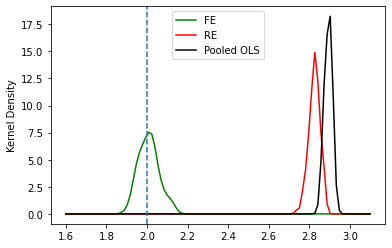

In [43]:
xx=np.linspace(1.6,3.1,num=100)  # 図を作成するために横軸の値を設定

kde_model_fe=gaussian_kde(bhat_fe_list)  # FE推定量のカーネル密度関数を計算

kde_model_re=gaussian_kde(bhat_re_list)  # RE推定量のカーネル密度関数を計算

kde_model_pool=gaussian_kde(bhat_pool_list)  # Pooled OLS推定量のカーネル密度関数を計算

plt.plot(xx, kde_model_fe(xx), 'g-', label='FE')  # FE推定量の分布プロット
plt.plot(xx, kde_model_re(xx),'r-', label='RE')  # RE推定量の分布プロット
plt.plot(xx, kde_model_pool(xx),'k-', label='Pooled OLS')  # RE推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')  # 真の値での垂直線
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

## 標準誤差の問題

(式３)の固定効果モデルを考えよう。パネル・データの場合，次の2つの問題が発生する場合がある。
* 残差の不均一分散
* 残差の自己相関

これらの問題が発生しても，基本的な仮定のもとでFE推定量は不偏性と一致性を満たす。しかし，係数の標準誤差は有効ではなくなり検定が無効となる。その対処方法として**クラスター頑健的推定**を使う。これは不均一分散の章で説明した不均一分散頑健的推定を**個体ごとの自己相関**（個体間の相関ではない）に対応できるように拡張し，パネル・データ用に考案された推定と理解すれば十分である。以下では，その使い方を説明する。

### 分散の確認

`linearmodels`には残差の均一分散を調べるBreusch-Pagan検定やWhite検定をおこなうメソッドは用意されていない。ここでは`statsmodels`を使いWooldridge (2016,p.253)で説明されているWhite検定に基づく検定をおこなう。次に必要な変数を作成する。

In [44]:
# 残差
u_hat = result_fe.resids.values.flatten()

# 被説明変数の予測値
y_hat = result_fe.fitted_values.values.flatten()

# DataFrameの作成
df_white = pd.DataFrame({'u_hat':u_hat,'y_hat':y_hat})

（上のコードの説明）
* `resids`は残差を`DataFrame`として取得する属性
* `fitted_values`は予測値を`DataFrame`として取得する属性
* `values`は`DataFrame`を`array`として返す属性
* `flatten()`は`array`が2次元になっているのを1次元に変換するメソッド
    * `array([[..],[..],...[...]])`を`array([....])`に変換する。

検定に使う式

$$\hat{u}^2=\beta_0+\beta_1\hat{y}+\beta_2\hat{y}^2+e$$

* $\text{H}_0：\beta_1=\beta_2=0$（均一分散）
* $\text{H}_A：$帰無仮説は成立しない

In [45]:
form_white = 'I(u_hat**2) ~ y_hat + I(y_hat**2)'

res_white = ols(form_white, data=df_white).fit()

print(res_white.summary().tables[1])
print('F検定のp値：',res_white.f_pvalue)

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1172      0.010     11.249      0.000       0.097       0.138
y_hat            -0.0205      0.048     -0.428      0.668      -0.114       0.073
I(y_hat ** 2)    -0.0550      0.099     -0.557      0.577      -0.248       0.138
F検定のp値： 0.4354339447413128


帰無仮説は棄却できない。

次に図を使い確認する。

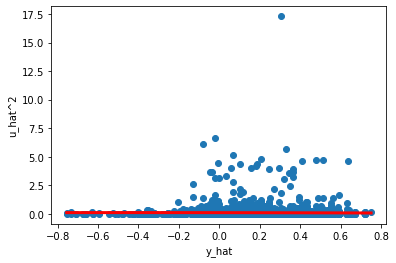

In [46]:
b0 = res_white.params[0] # beta0
b1 = res_white.params[1] # beta1
b2 = res_white.params[2] # beta2

xx = np.linspace(min(y_hat), max(y_hat), 100) # x軸の値
z = b0 + b1*xx + b1*xx**2  # 検定に使った式

plt.scatter(y_hat, u_hat**2)  # u_hat, y_hatの散布図
plt.plot(xx, z, 'red', linewidth=3)  # 検定の式の曲線
plt.xlabel('y_hat')
plt.ylabel('u_hat^2')
pass

（解説）
* 上の検定で推定した式は赤い線である。殆ど平行になっているため帰無仮説を棄却できなかった。
* 図の中で`y_hat`の値が`-0.2`を境に`u_hat`の変動はより大きくなっており，不均一分散の疑いが高い。

### 対処方法

＜使い方＞
* メソッド`fit()`に以下の引数を指定する。
    * 不均一分散だけの場合：`cov_type='clustered', cluster_entity=True`
    * 不均一分散と系列相関の場合：`cov_type='clustered', cluster_entity=True, cluster_time=True`


（注意）
* 係数の推定値は変わらない。
* 係数の標準誤差だけが修正され，有効な検定ができるようになる。


`wagepan`を使って上で推定した式にクラスター頑健的推定を使う。

＜不均一分散かだけの場合＞

In [47]:
mod_fe_clus1 = PanelOLS.from_formula(formula_fe, data=wagepan)

res_fe_clus1 = mod_fe_clus1.fit(cov_type='clustered', cluster_entity=True)

print(res_fe_clus1.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.0467     0.0210     2.2245     0.0262      0.0055      0.0878
union          0.0800     0.0227     3.5209     0.0004      0.0355      0.1246
expersq       -0.0052     0.0008    -6.4058     0.0000     -0.0068     -0.0036
d81            0.1512     0.0255     5.9195     0.0000      0.1011      0.2013
d82            0.2530     0.0286     8.8340     0.0000      0.1968      0.3091
d83            0.3544     0.0348     10.177     0.0000      0.2862      0.4227
d84            0.4901     0.0454     10.792     0.0000      0.4011      0.5792
d85            0.6175     0.0568     10.879     0.0000      0.5062      0.7288
d86            0.7655     0.0712     10.755     0.0000      0.6259      0.9050
d87            0.9250     0.0840     11.015     0.00

＜不均一分散と系列相関の場合＞

In [48]:
mod_fe_clus2 = PanelOLS.from_formula(formula_fe, data=wagepan)

res_fe_clus2 = mod_fe_clus2.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

print(res_fe_clus2.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.0467     0.0165     2.8312     0.0047      0.0144      0.0790
union          0.0800     0.0234     3.4242     0.0006      0.0342      0.1258
expersq       -0.0052     0.0008    -6.6189     0.0000     -0.0067     -0.0036
d81            0.1512     0.0066     23.020     0.0000      0.1383      0.1641
d82            0.2530     0.0168     15.027     0.0000      0.2200      0.2860
d83            0.3544     0.0255     13.886     0.0000      0.3044      0.4045
d84            0.4901     0.0374     13.113     0.0000      0.4168      0.5634
d85            0.6175     0.0499     12.366     0.0000      0.5196      0.7154
d86            0.7655     0.0646     11.858     0.0000      0.6389      0.8921
d87            0.9250     0.0776     11.913     0.00